# Avaliação de Um Modelo de Redes Neurais Artificiais em Neonatologia
Projeto final da Disciplina de Aprendizagem de Máquina - PPgEEC/UFRN

### Notebook 2 - TREINAMENTO COM TENSORFLOW

### 1.  Configurações Iniciais

In [1]:
# Importação de módulos
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.initializers

import wandb
import os
import logging

from dotenv import load_dotenv
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Precision, Recall
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Configuração dos gráficos
plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['text.usetex'] = True

In [3]:
# Carrega variáveis de ambiente
load_dotenv('config.env')
HASH_WANDB = os.getenv('HASH')

In [4]:
# Variáveis auxiliares
# Tamanho do conjunto de teste(fração do dataset que é utilizada como dados de teste)
val_size = 0.05

# Coeficiente de aleatoriedade
seed = 1618

# Variável alvo(target)
stratify = 'reanimacao'

# Artefato de entrada
input_artifact = 'mlprojfinal/df_rean.csv:latest'

# Tipo do artefato
artifact_type = 'TFTrain'

In [5]:
# Configurações de log
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

# Objeto logging
logger = logging.getLogger()

In [6]:
# Função auxiliar para plotar os gráficos
def plotGraphics(modelo):

    medidas = pd.DataFrame(modelo.history.history)

    fig, ax = plt.subplots(2,2)
    sns.lineplot(data=[medidas.loss, medidas.val_loss], ax=ax[0][0])
    sns.lineplot(data=[medidas.accuracy, medidas.val_accuracy], ax=ax[0][1])
    sns.lineplot(data=[medidas[medidas.columns[3]], medidas[medidas.columns[7]]], ax=ax[1][0])
    sns.lineplot(data=[medidas[medidas.columns[2]], medidas[medidas.columns[6]]], ax=ax[1][1])
    plt.show()

### 2. Aquisição do Artefato

In [7]:
# Login no wandb
!wandb login $HASH_WANDB --relogin

wandb: Appending key for api.wandb.ai to your netrc file: /Users/ericcalasans/.netrc


In [8]:
# Aquisição do artefato
run = wandb.init(project='mlprojfinal', job_type='tf_train')
artifact = run.use_artifact(input_artifact)
art_file = artifact.file()

wandb: Currently logged in as: ecalasans. Use `wandb login --relogin` to force relogin


In [9]:
# Transforma artefato em DataFrame
df = pd.read_csv(art_file)

In [10]:
df.shape

(345, 26)

In [11]:
# Retira coluna gerada no artefato
df.drop(columns='Unnamed: 0', axis=1, inplace=True)

In [12]:
df.groupby(['reanimacao']).reanimacao.count()

reanimacao
0    202
1    143
Name: reanimacao, dtype: int64

In [13]:
entradas = df.shape[1]

### 3.  Divisão dos conjuntos de Treino e Teste

In [14]:
X = df.iloc[:,:-1].values

In [15]:
y = df['reanimacao'].values

In [16]:
X

array([[1.        , 0.        , 1.        , ..., 0.        , 1.        ,
        0.72413793],
       [1.        , 0.        , 1.        , ..., 0.        , 1.        ,
        0.55172414],
       [1.        , 0.        , 1.        , ..., 1.        , 0.        ,
        0.44827586],
       ...,
       [1.        , 0.        , 1.        , ..., 0.        , 1.        ,
        0.68965517],
       [1.        , 0.        , 1.        , ..., 0.        , 1.        ,
        0.55172414],
       [1.        , 0.        , 1.        , ..., 0.        , 1.        ,
        0.62068966]])

In [17]:
y

array([0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0,

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=val_size, random_state=seed)

### 4. Construção da Rede

Para a quantidade de camadas escondidas($H^{i}$) não há um consenso.  As estratégias variam entre experimentação, intuição, busca heurística, etc.

Dado que o número de camadas escondidas foi escolhido, o número de neurônios de cada uma delas também é escolhido de forma não consensual.  Algumas práticas adotadas são apontadas neste artigo:  [How to determine the number of layers and neurons in the hidden layer?](https://medium.com/geekculture/introduction-to-neural-network-2f8b8221fbd3).

* Algum valor aleatório entre o tamanho da entrada e da saída;
* $\frac{2}{3}n_{entrada} + n_{saida}$;
* Menor que duas vezes o tamanho da entrada;

Usaremos, a princípio, duas camadas escondidas e a segunda regra para o número de neurônios de cada cmada, por parecer mais determinística.

In [19]:
# Cálculo do número de neurônios das camadas escondidas
neuronios_hl = np.ceil(2/3 * entradas + 1)
#neuronios_hl = 10

In [20]:
# Criação do modelo
modelo_padrao = Sequential()
modelo_padrao.add(Dense(units=neuronios_hl, activation='relu'))
modelo_padrao.add(Dense(units=neuronios_hl, activation='relu'))
modelo_padrao.add(Dense(1, activation='sigmoid'))

2022-07-20 06:27:34.905528: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
# Compilação do modelo
modelo_padrao.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [22]:
modelo_padrao.fit(x=X_train, y=y_train, epochs=300, validation_data=(X_test, y_test))

2022-07-20 06:27:42.839932: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/300
11/11 [==============================] - 5s 239ms/step - loss: 0.7094 - accuracy: 0.4776 - precision: 0.4281 - recall: 0.8016 - val_loss: 0.6567 - val_accuracy: 0.7778 - val_precision: 0.8182 - val_recall: 0.8182
Epoch 2/300
11/11 [==============================] - 0s 21ms/step - loss: 0.7039 - accuracy: 0.4837 - precision: 0.4001 - recall: 0.5115 - val_loss: 0.6771 - val_accuracy: 0.6667 - val_precision: 0.8571 - val_recall: 0.5455
Epoch 3/300
11/11 [==============================] - 0s 11ms/step - loss: 0.6882 - accuracy: 0.5896 - precision: 0.5023 - recall: 0.2611 - val_loss: 0.6941 - val_accuracy: 0.5000 - val_precision: 1.0000 - val_recall: 0.1818
Epoch 4/300
11/11 [==============================] - 0s 13ms/step - loss: 0.6813 - accuracy: 0.5808 - precision: 0.5058 - recall: 0.1079 - val_loss: 0.7079 - val_accuracy: 0.3889 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/300
11/11 [==============================] - 0s 12ms/step - loss: 0.6752 - accuracy: 0.

In [23]:
losses = pd.DataFrame(modelo_padrao.history.history)

In [24]:
losses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   loss           300 non-null    float64
 1   accuracy       300 non-null    float64
 2   precision      300 non-null    float64
 3   recall         300 non-null    float64
 4   val_loss       300 non-null    float64
 5   val_accuracy   300 non-null    float64
 6   val_precision  300 non-null    float64
 7   val_recall     300 non-null    float64
dtypes: float64(8)
memory usage: 18.9 KB


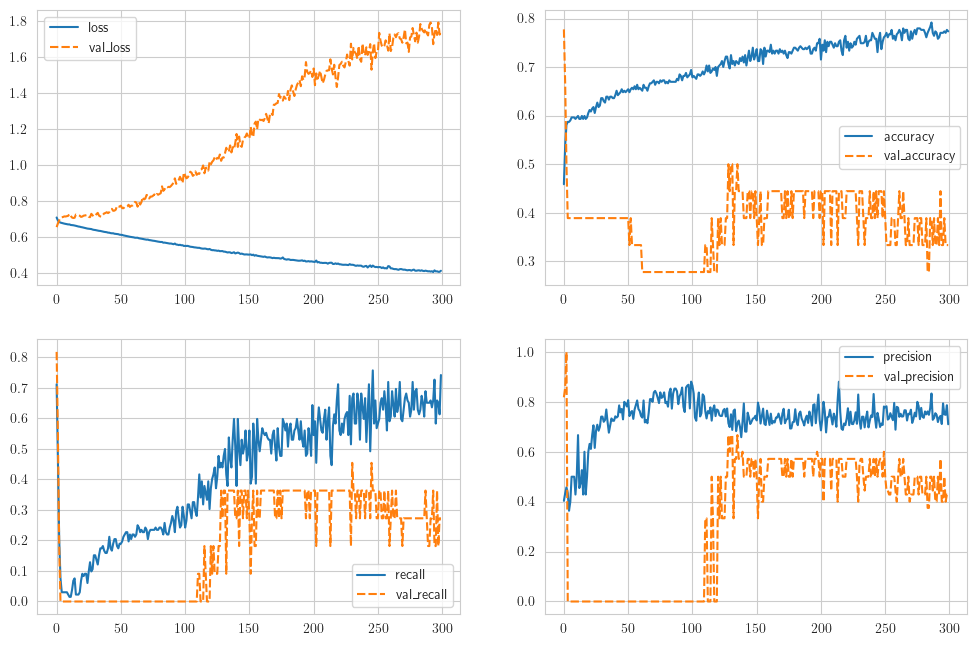

In [25]:
plotGraphics(modelo_padrao)

Vê-se claramente o problema do *overfitting*!  Agora serão aplicadas técnicas para tentar minimizar/corrigir tal situação.

### 5. Better Generalizing

### 5.1.  L2 Regularization

In [37]:
from tensorflow.keras.regularizers import l2

# Criação do modelo
modelo_l2 = Sequential()
modelo_l2.add(Dense(units=neuronios_hl, activation='relu', kernel_regularizer=l2(0.001)))
modelo_l2.add(Dense(units=neuronios_hl, activation='relu', kernel_regularizer=l2(0.001)))
modelo_l2.add(Dense(1, activation='sigmoid'))

In [38]:
l2_precision = tf.keras.metrics.Precision()
l2_recall = tf.keras.metrics.Recall()

modelo_l2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', l2_precision, l2_recall])

In [39]:
modelo_l2.fit(x=X_train, y=y_train, epochs=300, validation_data=(X_test, y_test))

Epoch 1/300
11/11 [==============================] - 3s 68ms/step - loss: 0.7240 - accuracy: 0.5794 - precision_2: 0.4311 - recall_2: 0.1508 - val_loss: 0.7988 - val_accuracy: 0.5000 - val_precision_2: 1.0000 - val_recall_2: 0.1818
Epoch 2/300
11/11 [==============================] - 0s 9ms/step - loss: 0.7349 - accuracy: 0.5703 - precision_2: 0.5554 - recall_2: 0.1052 - val_loss: 0.8067 - val_accuracy: 0.4444 - val_precision_2: 1.0000 - val_recall_2: 0.0909
Epoch 3/300
11/11 [==============================] - 0s 10ms/step - loss: 0.7190 - accuracy: 0.5862 - precision_2: 0.6133 - recall_2: 0.0604 - val_loss: 0.8112 - val_accuracy: 0.3889 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 4/300
11/11 [==============================] - 0s 9ms/step - loss: 0.7155 - accuracy: 0.6092 - precision_2: 0.7720 - recall_2: 0.0352 - val_loss: 0.7982 - val_accuracy: 0.3889 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 5/300
11/11 [==============================] - 0s 8m

In [40]:
losses_l2 = pd.DataFrame(modelo_l2.history.history)

In [41]:
losses_l2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   loss             300 non-null    float64
 1   accuracy         300 non-null    float64
 2   precision_2      300 non-null    float64
 3   recall_2         300 non-null    float64
 4   val_loss         300 non-null    float64
 5   val_accuracy     300 non-null    float64
 6   val_precision_2  300 non-null    float64
 7   val_recall_2     300 non-null    float64
dtypes: float64(8)
memory usage: 18.9 KB


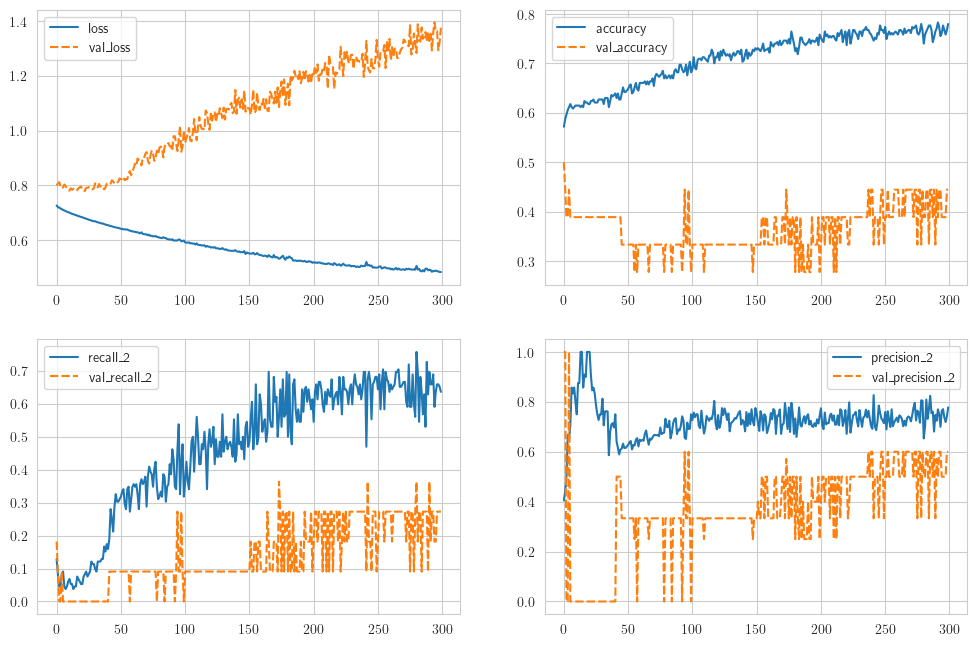

In [42]:
plotGraphics(modelo_l2)

### 5.2. Dropout

In [43]:
from tensorflow.keras.layers import Dropout

# Criação do modelo
modelo_dropout = Sequential()
modelo_dropout.add(Dense(units=neuronios_hl, activation='relu'))
modelo_dropout.add(Dropout(0.4))
modelo_dropout.add(Dense(units=neuronios_hl, activation='relu'))
modelo_dropout.add(Dropout(0.6))
modelo_dropout.add(Dense(1, activation='sigmoid'))

In [46]:
dropout_precision = tf.keras.metrics.Precision()
dropout_recall = tf.keras.metrics.Recall()

modelo_dropout.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', dropout_precision, dropout_recall])

In [47]:
modelo_dropout.fit(x=X_train, y=y_train, epochs=300, validation_data=(X_test, y_test))

Epoch 1/300
11/11 [==============================] - 5s 104ms/step - loss: 0.7099 - accuracy: 0.5177 - precision_5: 0.4057 - recall_5: 0.4737 - val_loss: 0.7865 - val_accuracy: 0.3889 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 2/300
11/11 [==============================] - 0s 35ms/step - loss: 0.8188 - accuracy: 0.4520 - precision_5: 0.3074 - recall_5: 0.3332 - val_loss: 0.7763 - val_accuracy: 0.3889 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 3/300
11/11 [==============================] - 0s 15ms/step - loss: 0.7471 - accuracy: 0.5349 - precision_5: 0.4066 - recall_5: 0.3423 - val_loss: 0.7632 - val_accuracy: 0.3889 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 4/300
11/11 [==============================] - 0s 18ms/step - loss: 0.7203 - accuracy: 0.5529 - precision_5: 0.3952 - recall_5: 0.3735 - val_loss: 0.7588 - val_accuracy: 0.3889 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 5/300
11/11 [====================

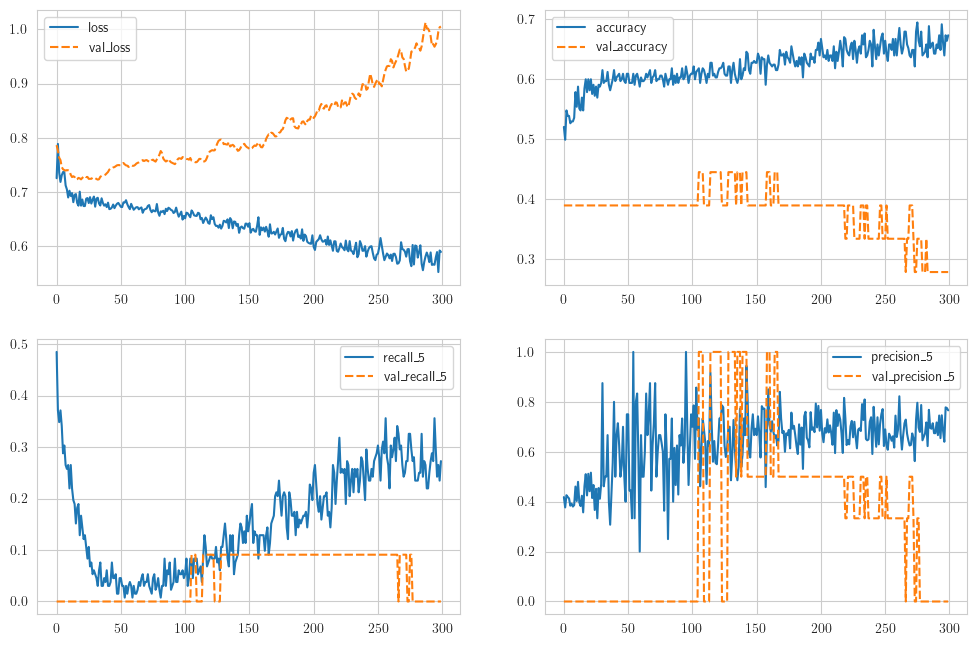

In [48]:
plotGraphics(modelo_dropout)

### 5.3. Restrição do Tamanho dos Pesos

### 5.3.1. unit_norm

In [49]:
from tensorflow.keras.constraints import unit_norm, min_max_norm

# Criação do modelo
modelo_unit_norm = Sequential()
modelo_unit_norm.add(Dense(units=neuronios_hl, activation='relu', kernel_constraint=unit_norm()))
modelo_unit_norm.add(Dense(units=neuronios_hl, activation='relu', kernel_constraint=unit_norm()))
modelo_unit_norm.add(Dense(1, activation='sigmoid'))

In [50]:
unit_norm_precision = tf.keras.metrics.Precision()
unit_norm_recall = tf.keras.metrics.Recall()

modelo_unit_norm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', unit_norm_precision, unit_norm_recall])

In [51]:
modelo_unit_norm.fit(x=X_train, y=y_train, epochs=300, validation_data=(X_test, y_test))

Epoch 1/300
11/11 [==============================] - 4s 82ms/step - loss: 0.8398 - accuracy: 0.3737 - precision_6: 0.3737 - recall_6: 1.0000 - val_loss: 0.6604 - val_accuracy: 0.6111 - val_precision_6: 0.6111 - val_recall_6: 1.0000
Epoch 2/300
11/11 [==============================] - 0s 10ms/step - loss: 0.7705 - accuracy: 0.4092 - precision_6: 0.4092 - recall_6: 1.0000 - val_loss: 0.6634 - val_accuracy: 0.6111 - val_precision_6: 0.6111 - val_recall_6: 1.0000
Epoch 3/300
11/11 [==============================] - 0s 9ms/step - loss: 0.7362 - accuracy: 0.4109 - precision_6: 0.4023 - recall_6: 1.0000 - val_loss: 0.6733 - val_accuracy: 0.6111 - val_precision_6: 0.6250 - val_recall_6: 0.9091
Epoch 4/300
11/11 [==============================] - 0s 9ms/step - loss: 0.7246 - accuracy: 0.4124 - precision_6: 0.3775 - recall_6: 0.9430 - val_loss: 0.6824 - val_accuracy: 0.7222 - val_precision_6: 0.7500 - val_recall_6: 0.8182
Epoch 5/300
11/11 [==============================] - 0s 13ms/step - loss: 

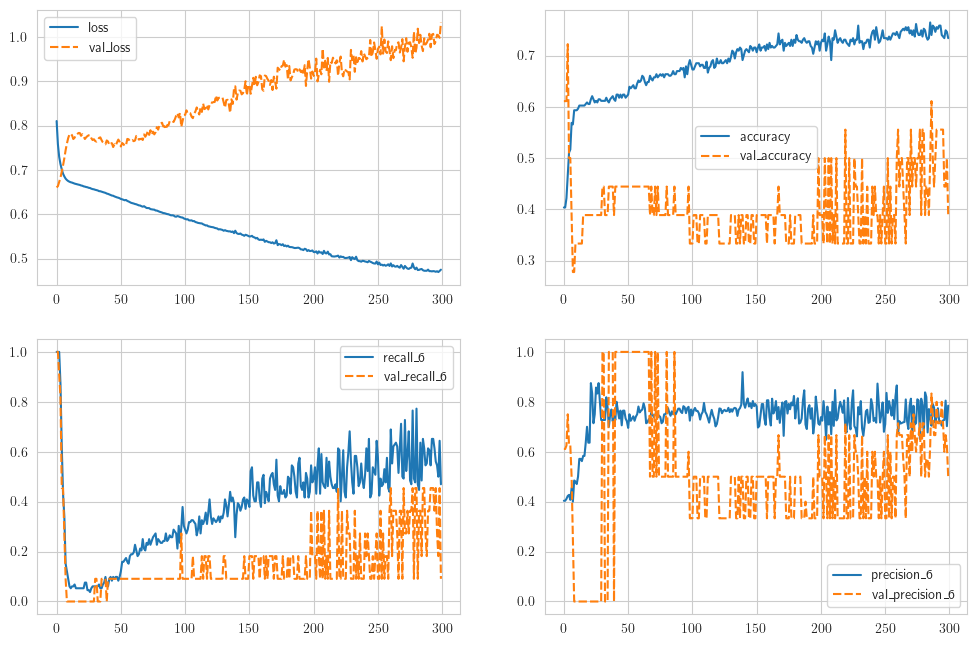

In [52]:
plotGraphics(modelo_unit_norm)

### 5.3.2. min_max_norm

In [53]:
# Criação do modelo
modelo_minmax = Sequential()
modelo_minmax.add(Dense(units=neuronios_hl, activation='relu', kernel_constraint=min_max_norm(min_value=-0.5, max_value=1.0)))
modelo_minmax.add(Dense(units=neuronios_hl, activation='relu', kernel_constraint=min_max_norm(min_value=-0.5, max_value=1.0)))
modelo_minmax.add(Dense(1, activation='sigmoid'))

In [54]:
minmax_precision = tf.keras.metrics.Precision()
minmax_recall = tf.keras.metrics.Recall()

modelo_minmax.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', minmax_precision, minmax_recall])

In [55]:
modelo_minmax.fit(X_train, y_train, epochs=300, validation_data=(X_test, y_test))

Epoch 1/300
11/11 [==============================] - 3s 89ms/step - loss: 0.7094 - accuracy: 0.4041 - precision_7: 0.3843 - recall_7: 0.9745 - val_loss: 0.7022 - val_accuracy: 0.5000 - val_precision_7: 0.5625 - val_recall_7: 0.8182
Epoch 2/300
11/11 [==============================] - 0s 16ms/step - loss: 0.6966 - accuracy: 0.4972 - precision_7: 0.4341 - recall_7: 0.6613 - val_loss: 0.7091 - val_accuracy: 0.1667 - val_precision_7: 0.1667 - val_recall_7: 0.0909
Epoch 3/300
11/11 [==============================] - 0s 12ms/step - loss: 0.6876 - accuracy: 0.5661 - precision_7: 0.4178 - recall_7: 0.2142 - val_loss: 0.7178 - val_accuracy: 0.3889 - val_precision_7: 0.5000 - val_recall_7: 0.0909
Epoch 4/300
11/11 [==============================] - 0s 10ms/step - loss: 0.6830 - accuracy: 0.5758 - precision_7: 0.2692 - recall_7: 0.0489 - val_loss: 0.7266 - val_accuracy: 0.4444 - val_precision_7: 1.0000 - val_recall_7: 0.0909
Epoch 5/300
11/11 [==============================] - 0s 9ms/step - loss:

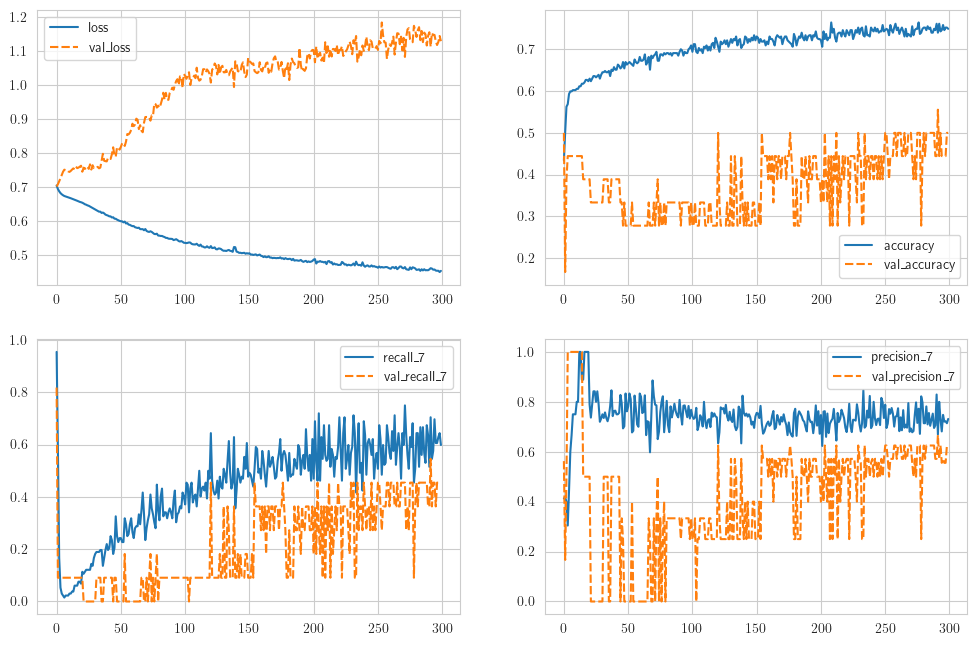

In [56]:
plotGraphics(modelo_minmax)

### 5.4.  Early Stopping

In [95]:
# Criação do modelo
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

modelo_es = Sequential()
modelo_es.add(Dense(units=neuronios_hl, activation='relu'))
modelo_es.add(Dense(units=neuronios_hl, activation='relu'))
modelo_es.add(Dense(1, activation='sigmoid'))

In [96]:
es_precision = tf.keras.metrics.Precision(name='es_precision')
es_recall = tf.keras.metrics.Recall(name='es_recall')

In [97]:
es = EarlyStopping(monitor=es_recall.name, mode='max', patience=50, verbose=1)
mc = ModelCheckpoint('best_model.h5', monitor=es_recall.name, mode='max', verbose=1,
                     save_best_only=True)

In [98]:
modelo_es.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', es_precision, es_recall])

In [99]:
modelo_es.fit(x=X_train, y=y_train, epochs=300, validation_data=(X_test, y_test), callbacks=[es, mc])

Epoch 1/300
11/11 [==============================] - 2s 82ms/step - loss: 0.6934 - accuracy: 0.5775 - es_precision: 0.0000e+00 - es_recall: 0.0000e+00 - val_loss: 0.7653 - val_accuracy: 0.3333 - val_es_precision: 0.0000e+00 - val_es_recall: 0.0000e+00

Epoch 00001: es_recall improved from -inf to 0.00000, saving model to best_model.h5
Epoch 2/300
11/11 [==============================] - 0s 7ms/step - loss: 0.6678 - accuracy: 0.6232 - es_precision: 0.2083 - es_recall: 0.0056 - val_loss: 0.7496 - val_accuracy: 0.3333 - val_es_precision: 0.0000e+00 - val_es_recall: 0.0000e+00

Epoch 00002: es_recall improved from 0.00000 to 0.00758, saving model to best_model.h5
Epoch 3/300
11/11 [==============================] - 0s 8ms/step - loss: 0.6818 - accuracy: 0.5838 - es_precision: 0.5278 - es_recall: 0.0188 - val_loss: 0.7431 - val_accuracy: 0.3333 - val_es_precision: 0.0000e+00 - val_es_recall: 0.0000e+00

Epoch 00003: es_recall did not improve from 0.00758
Epoch 4/300
11/11 [=================

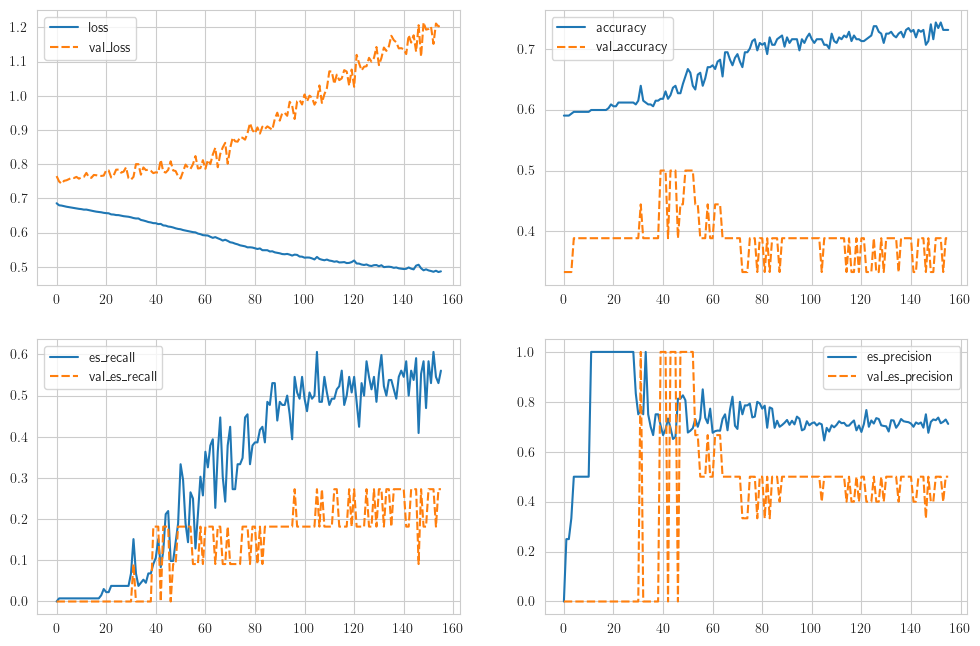

In [100]:
plotGraphics(modelo_es)

---

### 6. Better Learning

Nesta seção aplicaremos os conhecimentos da seção *Better Learning* no *dataset*.

### 6.1.  Inicialização dos Pesos

### 6.1.1.  Inicialização com zeros

In [29]:
#  Criação dos modelo
zeros = tf.keras.initializers.Zeros()

modelo_zeros = Sequential()
modelo_zeros.add(Dense(units=neuronios_hl, activation='relu', kernel_initializer=zeros))
modelo_zeros.add(Dense(units=neuronios_hl, activation='relu', kernel_initializer=zeros))
modelo_zeros.add(Dense(1, activation='sigmoid'))

In [30]:
z_precision = tf.keras.metrics.Precision(name='z_precision')
z_recall = tf.keras.metrics.Recall(name='z_recall')

In [31]:
modelo_zeros.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', z_precision, z_recall])

In [32]:
modelo_zeros.fit(x=X_train, y=y_train, epochs=300, verbose=1, validation_data=(X_test, y_test))

Epoch 1/300
11/11 [==============================] - 3s 73ms/step - loss: 0.6929 - accuracy: 0.5902 - z_precision: 0.0000e+00 - z_recall: 0.0000e+00 - val_loss: 0.6943 - val_accuracy: 0.3889 - val_z_precision: 0.0000e+00 - val_z_recall: 0.0000e+00
Epoch 2/300
11/11 [==============================] - 0s 9ms/step - loss: 0.6920 - accuracy: 0.5985 - z_precision: 0.0000e+00 - z_recall: 0.0000e+00 - val_loss: 0.6952 - val_accuracy: 0.3889 - val_z_precision: 0.0000e+00 - val_z_recall: 0.0000e+00
Epoch 3/300
11/11 [==============================] - 0s 13ms/step - loss: 0.6913 - accuracy: 0.5921 - z_precision: 0.0000e+00 - z_recall: 0.0000e+00 - val_loss: 0.6962 - val_accuracy: 0.3889 - val_z_precision: 0.0000e+00 - val_z_recall: 0.0000e+00
Epoch 4/300
11/11 [==============================] - 0s 10ms/step - loss: 0.6913 - accuracy: 0.5650 - z_precision: 0.0000e+00 - z_recall: 0.0000e+00 - val_loss: 0.6971 - val_accuracy: 0.3889 - val_z_precision: 0.0000e+00 - val_z_recall: 0.0000e+00
Epoch 5/3

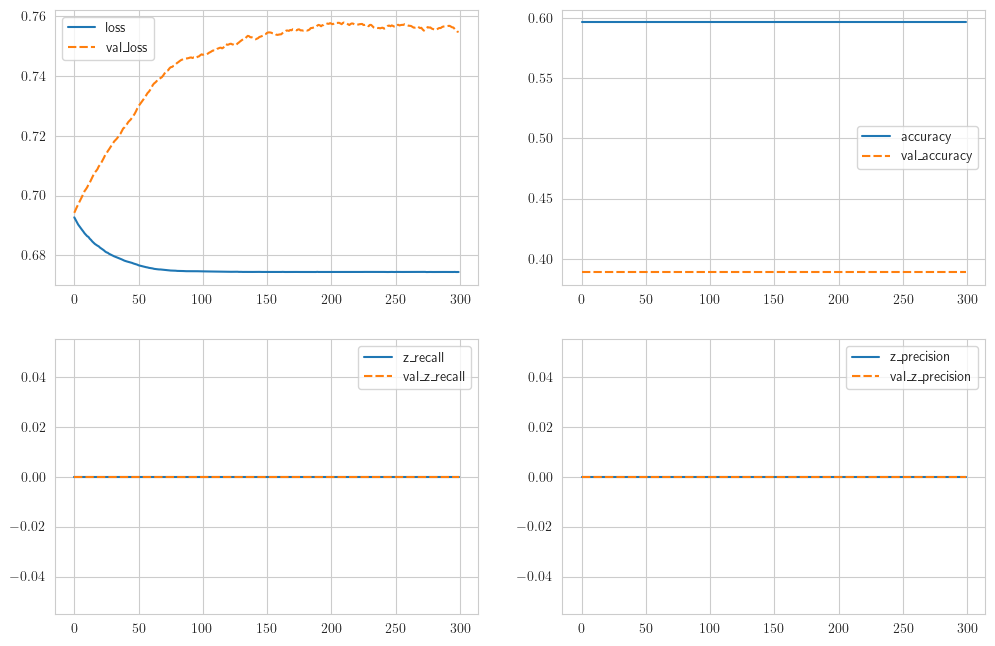

In [33]:
plotGraphics(modelo_zeros)

### 6.1.2.  Inicialização Aleatória

In [40]:
#  Criação do Modelo
alea = tf.keras.initializers.RandomNormal(mean=0, stddev=1)

modelo_alea = Sequential()
modelo_alea.add(Dense(units=neuronios_hl, activation='relu', kernel_initializer=alea))
modelo_alea.add(Dense(units=neuronios_hl, activation='relu', kernel_initializer=alea))
modelo_alea.add(Dense(1, activation='sigmoid'))

In [41]:
alea_precision = tf.keras.metrics.Precision(name='alea_precision')
alea_recall = tf.keras.metrics.Recall(name='alea_recall')

In [44]:
modelo_alea.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', alea_precision, alea_recall])

In [28]:
modelo_alea.fit(x=X_train, y=y_train, epochs=300, verbose=0, validation_data=(X_test, y_test))

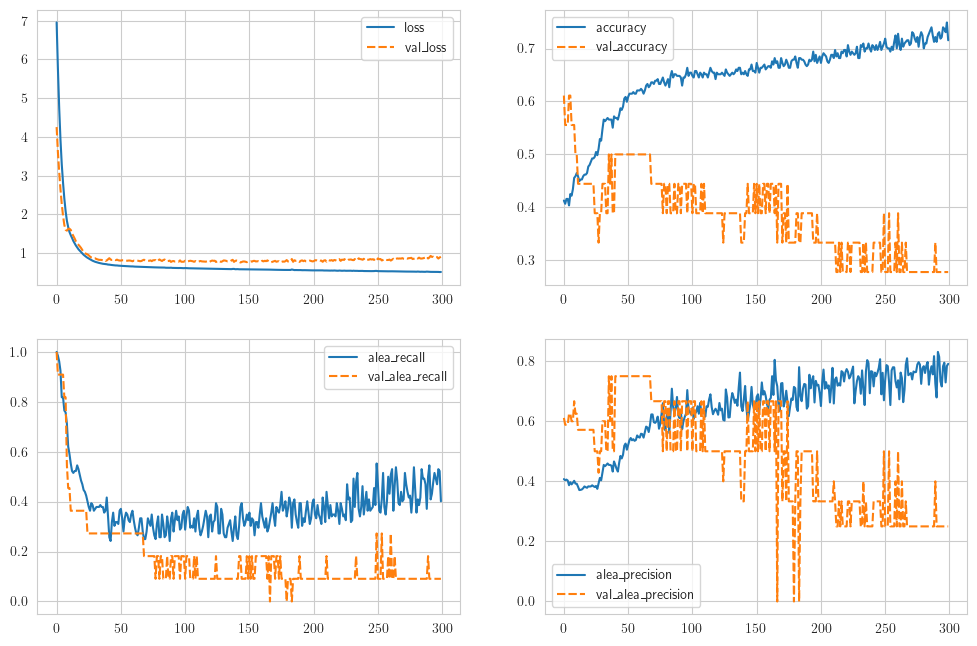

In [29]:
plotGraphics(modelo_alea)

Pela primera vez observamos *Underfitting* com posterior melhora de aprendizagem.  O que acontece com o aumento das épocas?  Melhora a acurácia do modelo???

Podemos combinar esta técnica com o **Early Stopping**.

In [45]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping_recall = EarlyStopping(monitor='accuracy', mode='max', patience=50, verbose=0)

In [46]:
modelo_alea.fit(x=X_train, y=y_train, epochs=1000, verbose=0, validation_data=(X_test, y_test), callbacks=[early_stopping_recall])

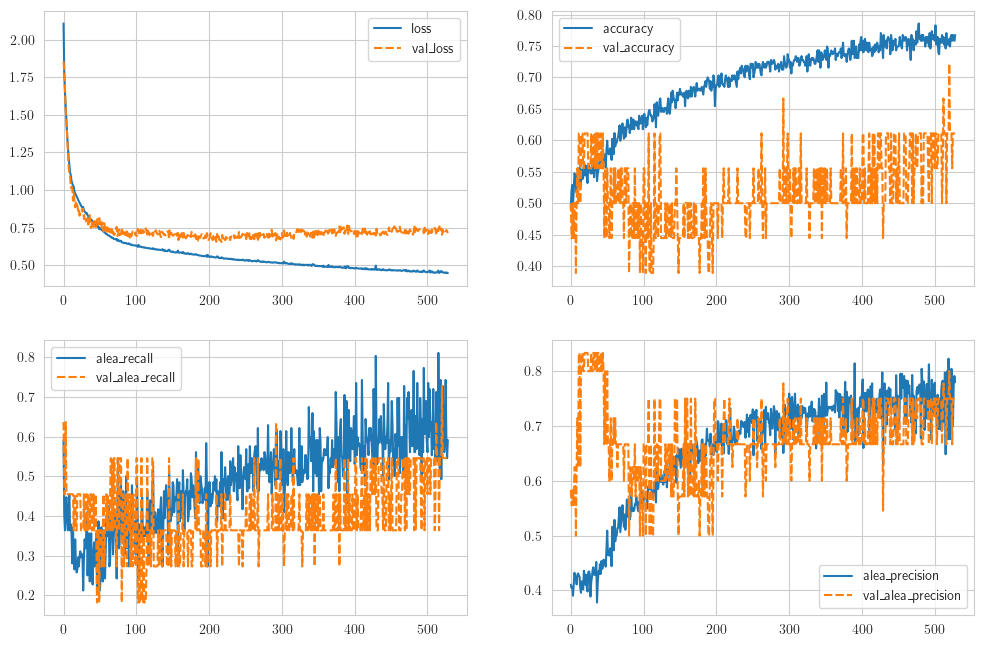

In [47]:
plotGraphics(modelo_alea)

### 7.  Batch Normalization